In [29]:
!pip install yfinance
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.5 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

import yfinance as yf

In [12]:
def fetch_stock_data_exchange(stock_code):
  stock = yf.Ticker(f"{stock_code}.TW")
  data = stock.history(period='max',interval='1d')
  return data

In [17]:
data['Open']

,Open
Date,
2003-08-25 00:00:00+08:00,19.896518
2003-08-26 00:00:00+08:00,19.165617
2003-08-27 00:00:00+08:00,18.678355
2003-08-28 00:00:00+08:00,17.378990
2003-08-29 00:00:00+08:00,16.648099
...,...
2024-10-16 00:00:00+08:00,221.000000
2024-10-17 00:00:00+08:00,223.500000
2024-10-18 00:00:00+08:00,229.000000


In [18]:
stock_code = '6139'  # 替換為實際的股號
data = fetch_stock_data_exchange(stock_code)
data.dropna(inplace=True)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-08-25 00:00:00+08:00,19.896518,19.896518,18.597144,18.921984,1914209,0.0,0.0
2003-08-26 00:00:00+08:00,19.165615,19.490456,17.947460,18.191092,3817729,0.0,0.0
2003-08-27 00:00:00+08:00,18.678353,18.678353,17.541409,17.541409,2476990,0.0,0.0
2003-08-28 00:00:00+08:00,17.378986,17.622618,16.404465,16.648094,3575433,0.0,0.0
2003-08-29 00:00:00+08:00,16.648099,17.785042,16.242049,17.785042,3437350,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-16 00:00:00+08:00,221.000000,225.500000,220.000000,225.500000,1850833,0.0,0.0
2024-10-17 00:00:00+08:00,223.500000,227.500000,223.000000,226.500000,1248440,0.0,0.0
2024-10-18 00:00:00+08:00,229.000000,229.500000,224.000000,224.500000,1362511,0.0,0.0


In [19]:
model = ARIMA(data['Close'], order=(5,1,0))
results = model.fit()
forecast = results.forecast(steps=30)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

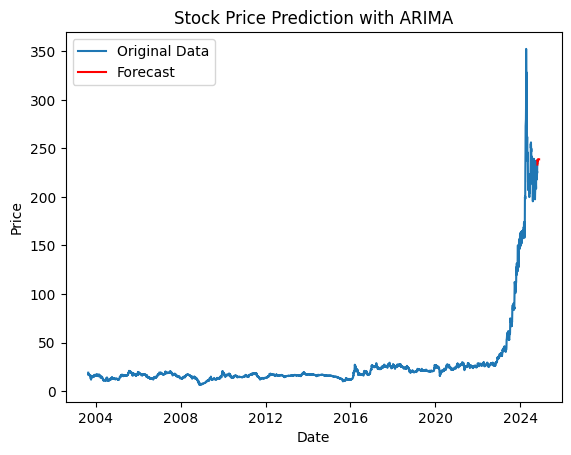

In [20]:
# 绘制原始数据
plt.plot(data.index, data['Close'], label='Original Data')

# 绘制预测结果
plt.plot(pd.date_range(start=data.index[-1], periods=31)[1:], forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction with ARIMA')
plt.legend()
plt.show()


In [37]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import math

In [38]:
# sma cross strategy
class SmaCross(bt.Strategy):
    # 交易紀錄
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    # 設定交易參數
    params = dict(
        ma_period_short=5,
        ma_period_long=10
    )

    def __init__(self):
        # 均線交叉策略
        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)

        # 使用自訂的sizer函數，將帳上的錢all-in
        self.setsizer(sizer())

        # 用開盤價做交易
        self.dataopen = self.datas[0].open

    def next(self):
        # 帳戶沒有部位
        if not self.position:
            # 5ma往上穿越20ma
            if self.crossover > 0:
                # 印出買賣日期與價位
                self.log('BUY ' + ', Price: ' + str(self.dataopen[0]))
                # 使用開盤價買入標的
                self.buy(price=self.dataopen[0])
        # 5ma往下穿越20ma
        elif self.crossover < 0:
            # 印出買賣日期與價位
            self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
            # 使用開盤價賣出標的
            self.close(price=self.dataopen[0])

# 計算交易部位
class sizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return math.floor(cash/data[1])
        else:
            return self.broker.getposition(data)

In [39]:
data = bt.feeds.PandasData(dataname=yf.download('6139.TW'))
# 初始化cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SmaCross)
# run backtest
cerebro.run()
# plot diagram
cerebro.plot()

[*********************100%***********************]  1 of 1 completed


2003-09-18, BUY , Price: 56.612430572509766
2003-10-17, BUY , Price: 51.16892623901367
2003-10-29, SELL , Price: 47.90282440185547
2003-11-05, BUY , Price: 48.71935272216797
2003-11-17, BUY , Price: 48.99152755737305
2003-11-25, BUY , Price: 49.53588104248047
2003-12-19, SELL , Price: 53.89067840576172
2004-01-01, BUY , Price: 52.80197525024414
2004-01-02, SELL , Price: 52.80197525024414
2004-01-05, BUY , Price: 53.074153900146484
2004-01-23, BUY , Price: 56.06808090209961
2004-02-03, SELL , Price: 56.06808090209961
2004-02-20, BUY , Price: 55.52372741699219
2004-04-01, BUY , Price: 50.08022689819336
2004-04-20, BUY , Price: 48.71935272216797
2004-05-24, BUY , Price: 38.64887237548828
2004-06-25, BUY , Price: 37.01581954956055
2004-08-20, BUY , Price: 36.58034133911133
2004-09-03, BUY , Price: 38.2133903503418
2004-09-27, BUY , Price: 43.112545013427734
2004-11-11, BUY , Price: 42.78593444824219
2004-11-19, BUY , Price: 42.78593444824219
2004-12-09, BUY , Price: 39.19322204589844
2004-

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]